In [1]:
from neuron import h, gui
from neuron.units import ms, mV

In [2]:
h.load_file('stdrun.hoc')

1.0

In [3]:
class Cell:
    
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0                  
        h.define_shape()
        self._rotate_z(theta)                                
        self._set_position(x, y, z)    

        # make cell record its spike times
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None,
                                        sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        # Keep track of NetCon's attched to the cell
        self._ncs = []
        
        # vector for tracking membrane potential 
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)
        
        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime,
                               sec.z3d(i), sec.diam3d(i))

In [4]:
class BallAndStick(Cell):
    
    
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV
            
        # Create a synapse on the dendrite
        self.syn = h.ExpSyn(self.dend(0.5))
        self.syn.tau = 2 * ms

In [5]:
mycell = BallAndStick(0, 0, 0, 0, 0)
del mycell

## Conctruct and position our cells

In [6]:
def create_n_BallAndStick(n, r):
    """n = number of cells; r = radius of circle"""
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells    

In [7]:
my_cells = create_n_BallAndStick(5, 50)

In [8]:
ps = h.PlotShape(True)
ps.show(0)

1.0

## A first synapse, and input via a NetStim

Let's now stimulate a cell and see that it responds appropriately.
Instead of stimulating with a current electrode as we did before, let's assign a virtual synapse so that we get acquainted with driving the cells through synaptic events. <br>

Event-based communication between objects in NEUROn takes place via network connection objects called NetCons. Each NetCon has a source and target, where the source is typically a spike threshold
detector. When a spike is detected, the NetCon sends a message to a target, usually a synapse on a postsynaptic cell. <br>

A NetStim is a spike generator that can be used as the source in a 
NetCon, behaving as external input onto the synapse of a target cell. The following code makes a NetStim object that generates one 
spike at time t=9. The NetCon then adds another ms delay to deliver a synaptic event at time t=10 onto the first cell.  <br>

The code below makes a stimulator and attaches it to a synapse object (ExpSyn) that behaves much like an AMPA synase - it conducts current as a decaying exponential function. 

In [9]:
stim = h.NetStim() # Make a new stimulator

# Attach it to a synapse in the middle of the dendrite
# of the first cell in the network. (Named 'syn_' to avoid
# being overwritten with the 'syn' var assigned later.)
syn_ = h.ExpSyn(my_cells[0].dend(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

In [10]:
syn_.tau = 2 * ms

# Running and Plotting the Simulation

Right now, there are no synapses between cells, but let's confirm 
that the first cell works correctly.

In [11]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [12]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

In [13]:
%matplotlib inline

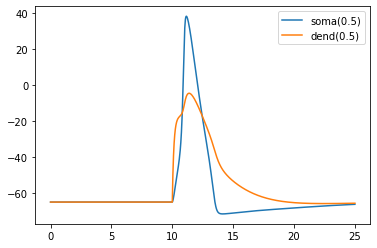

In [14]:
import matplotlib.pyplot as plt
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

## Recording synaptic conductance

In [15]:
syn_i = h.Vector().record(syn_._ref_i)

In [16]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

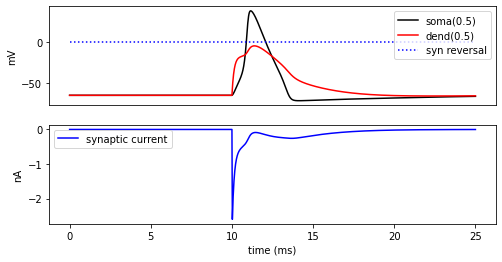

In [17]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
rev_plot = ax1.plot([t[0], t[-1]], [syn_.e, syn_.e], label='syn reversal',
        color='blue', linestyle=':')
ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([]) # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')
plt.show()

## Connecting the cells

For this particular model, the particular dynamics of the axons do not need to be explicitly modeled. When the soma fires an action potential, we assume the spike propagates down the axon and induces a synaptic event onto the dendrite of the target cell with some delay. We can therefore connect a spike detector in the soma of the presynaptic cell that triggers a synaptic event in the target cell via a **NetCon**.

In [18]:
syns = []
netcons = []
for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 3 * ms
    netcons.append(nc)
    syns.append(syn)

In [19]:
print(netcons)
print(syns)

[NetCon[1], NetCon[2], NetCon[3], NetCon[4], NetCon[5]]
[ExpSyn[1], ExpSyn[2], ExpSyn[3], ExpSyn[4], ExpSyn[5]]


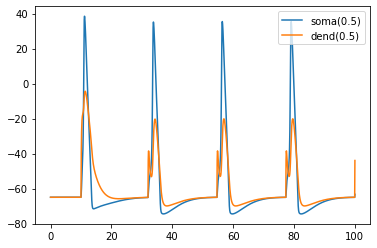

In [20]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

Here we of course plotting only one cell, but the fact that it spikes more than once suggest that spikes are being transmitted throughout the network <br>
We can ask of our existing `NetCon` to record spike times in NEURON `Vector` objects using `NetCon.record`

In [21]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

In [22]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [23]:
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [10.925000000099914, 33.575000000099074, 56.20000000010422, 78.82500000010936]
cell 1: [15.450000000099656, 38.1000000001001, 60.72500000010525, 83.35000000011038]
cell 2: [19.9750000000994, 42.62500000010113, 65.25000000010627, 87.87500000011141]
cell 3: [24.500000000099142, 47.15000000010216, 69.7750000001073, 92.40000000011244]
cell 4: [29.025000000098885, 51.67500000010319, 74.30000000010833, 96.92500000011347]


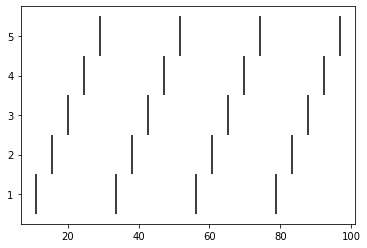

In [24]:
plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(spike_times_vec, i + 0.5, i + 1.5)
plt.show()